In [1]:
# encoding: utf-8
import pandas as pd
import random
import jieba
import gc
import numpy as np

In [2]:
jieba.load_userdict("../data/Trump_dict.txt")

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/z8/g1n0vfrn7wdg2c3dz9q7zjm80000gn/T/jieba.cache
Loading model cost 0.397 seconds.
Prefix dict has been built succesfully.


In [3]:
#Trump_Tag.xlsx 是將所有有提到川普的句子以人工的方式針對作者的想法進行1, 0, -1三種類別貼標
data = pd.read_excel("../data/Trump_Tag.xlsx")
print data.shape
data.head()

(2310, 5)


,author,dt,link,line,支持走向
0,david190,2016-06-02,https://www.ptt.cc/bbs/Stock/M.1464852416.A.66...,由於美國有第三大黨要出候選人 分希拉蕊的票如果剛好就讓 川普當選的話 應該會對美股長期走勢有...,0
1,Edward,2016-06-06,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,卻時常在鏡頭面前凸搥的川普如果當選美國總統,-1
2,Edward,2016-06-06,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,桑默斯列舉五大理由解釋為何對川普如此憂心,-1
3,Edward,2016-06-06,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,當中首要是川普亂無章法的政策風險,-1
4,Edward,2016-06-06,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,如川普主張的減稅措施預估可能超過十兆美元,0


In [4]:
#進行抽樣並將結果儲存
test = random.sample(range(0,2310),462)
data.loc[:,'sampled'] = 0
data.iloc[test,5] = 1
data.to_csv("../outcome/Raw_model_data.csv",index=False,encoding="utf-8")

In [6]:
data = pd.read_csv("../outcome/Raw_model_data.csv",encoding='utf-8')
print data.shape
data.head()

(2310, 6)


,author,dt,link,line,支持走向,sampled
0,david190,2016-06-02,https://www.ptt.cc/bbs/Stock/M.1464852416.A.66...,由於美國有第三大黨要出候選人 分希拉蕊的票如果剛好就讓 川普當選的話 應該會對美股長期走勢有...,0,0
1,Edward,2016-06-06,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,卻時常在鏡頭面前凸搥的川普如果當選美國總統,-1,0
2,Edward,2016-06-06,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,桑默斯列舉五大理由解釋為何對川普如此憂心,-1,0
3,Edward,2016-06-06,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,當中首要是川普亂無章法的政策風險,-1,0
4,Edward,2016-06-06,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,如川普主張的減稅措施預估可能超過十兆美元,0,0


In [7]:
#確定建模資料和測試資料在支持走向的部分趨勢是相同的
train_data = data[data.sampled == 0]
test_data = data[data.sampled == 1]
print "建模資料"
print train_data[u"支持走向"].value_counts()
print "\n測試資料"
print test_data[u'支持走向'].value_counts()

建模資料
 0    1164
 1     372
-1     312
Name: 支持走向, dtype: int64

測試資料
 0    297
-1     87
 1     78
Name: 支持走向, dtype: int64


## 找出正評及負評之間是否有什麼不一樣的常出現字

In [8]:
#將正負評資料切開來處理
positive = train_data[train_data[u'支持走向'] == 1]
negative = train_data[train_data[u'支持走向'] == -1]

In [11]:
#看正評字的出現分佈
positive = positive.drop(['author','dt','link',u'支持走向','sampled'],axis=1)
positive.loc[:,'sep'] = positive.line.map(lambda x:list(jieba.cut(x)))
positive_word = {}
for index,row in positive.iterrows():
    for word in row['sep']:
        if word in positive_word:
            positive_word[word] += 1
        else:
            positive_word[word] = 1
for row in sorted(positive_word,key=positive_word.get,reverse=True):
    if (len(row) >1)&(positive_word[row] >7):
        print row, positive_word[row]

川普 347
當選 79
希拉蕊 48
美國 38
民調 20
原文 17
就是 16
可能 16
真的 15
領先 15
經濟 14
美股 14
覺得 13
應該 13
總統 11
XD 10
政策 10
機會 9
勝選 9
台股 9
內容 9
支持 9
機率 9
因為 9
連結 8
結果 8
脫歐 8
一定 8
... 8
所以 8
希望 8
必須 8


In [14]:
negative.loc[:,'sep'] = negative.line.map(lambda x:list(jieba.cut(x)))
negative_word = {}
for index,row in negative.iterrows():
    for word in row['sep']:
        if word in negative_word:
            negative_word[word] += 1
        else:
            negative_word[word] = 1
for row in sorted(negative_word,key=negative_word.get,reverse=True):
    if (len(row) >1)&(negative_word[row] >7):
        print row, negative_word[row]

川普 302
當選 83
美國 34
希拉蕊 34
現在 19
應該 16
經濟 14
空軍 14
總統 13
真的 12
不會 12
台股 11
可能 11
還是 10
升息 10
... 10
大家 10
美股 10
民調 9
機率 9
政策 9
就是 8
不是 8
上任 8
多軍 8


In [15]:
#看看哪些是獨有的關鍵字
positive_key = set(positive_word)
negative_key = set(negative_word)
both = positive_key & negative_key
positive_only = positive_key - negative_key
negative_only = negative_key - positive_key

In [16]:
#視覺化字數分配的情形
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc')

In [17]:
#前置資料處理
positive_data = pd.DataFrame(list(positive_word.items()),columns=['positive_word','cnt'])
negative_data = pd.DataFrame(list(negative_word.items()),columns=['negative_word','cnt'])
positive_data = positive_data.sort_values(by=['cnt'],ascending=[False])
negative_data = negative_data.sort_values(by=['cnt'],ascending=[False])

<IPython.core.display.Javascript object>


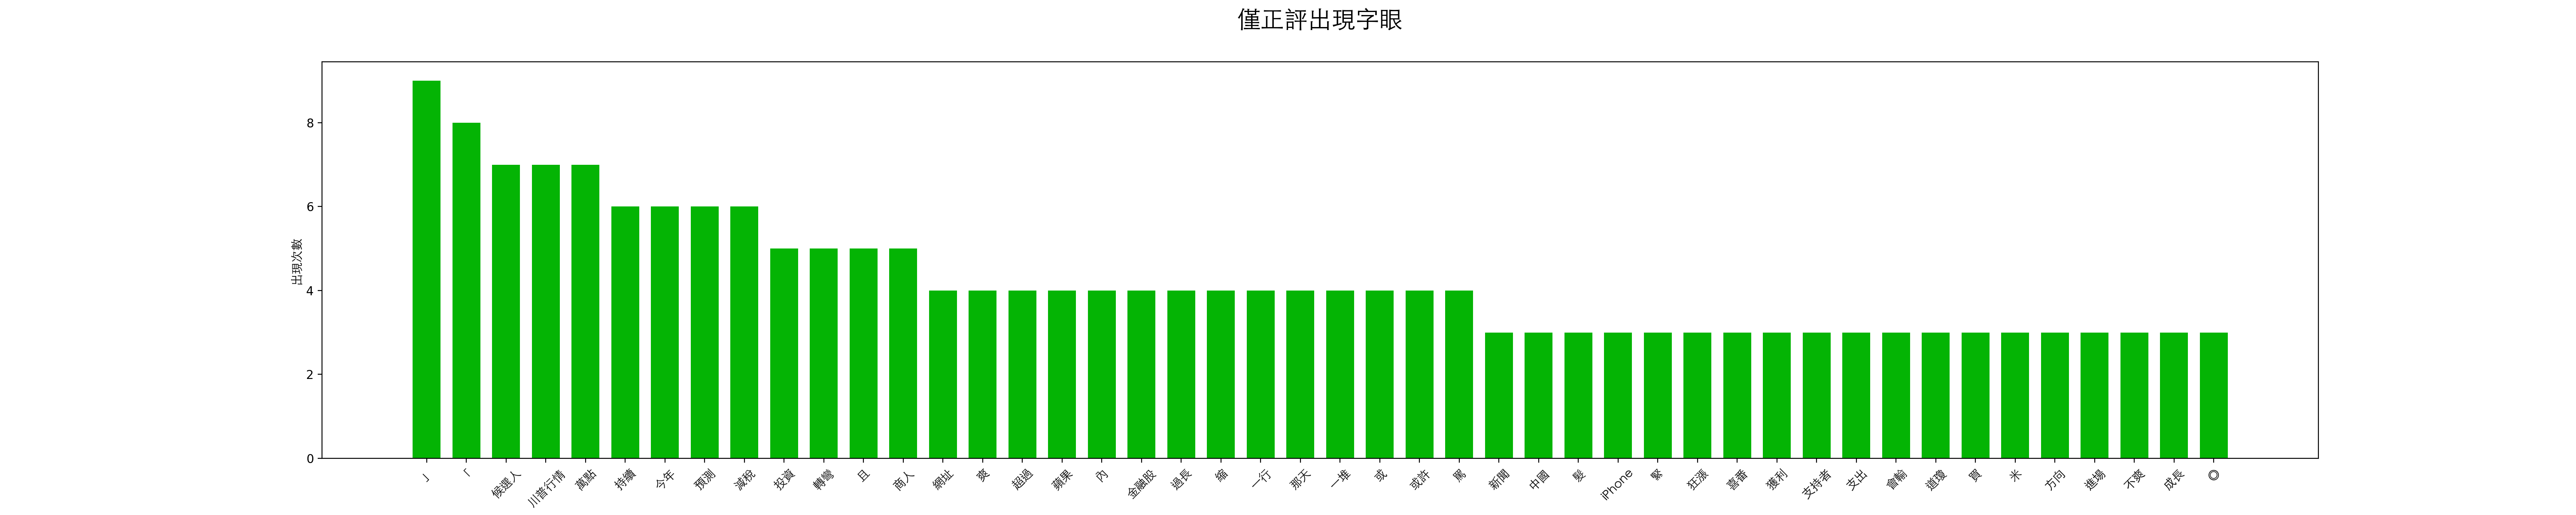

In [18]:
#繪製正評字彙分佈長條圖
plt.figure(figsize=(30,6))
y = positive_data[(positive_data.positive_word.isin(positive_only))&(positive_data.cnt > 2)]['cnt']
label = positive_data[(positive_data.positive_word.isin(positive_only))&(positive_data.cnt > 2)]['positive_word']
x = range(len(y))
width = 0.7
plt.bar(x,y,width = width,color="#04B404")
plt.xticks(x,label,fontproperties=myfont,rotation=45,fontsize=10)
plt.title(u"僅正評出現字眼\n",fontsize = 20,fontproperties=myfont)
plt.ylabel(u"出現次數",fontproperties=myfont)
plt.show()

<IPython.core.display.Javascript object>


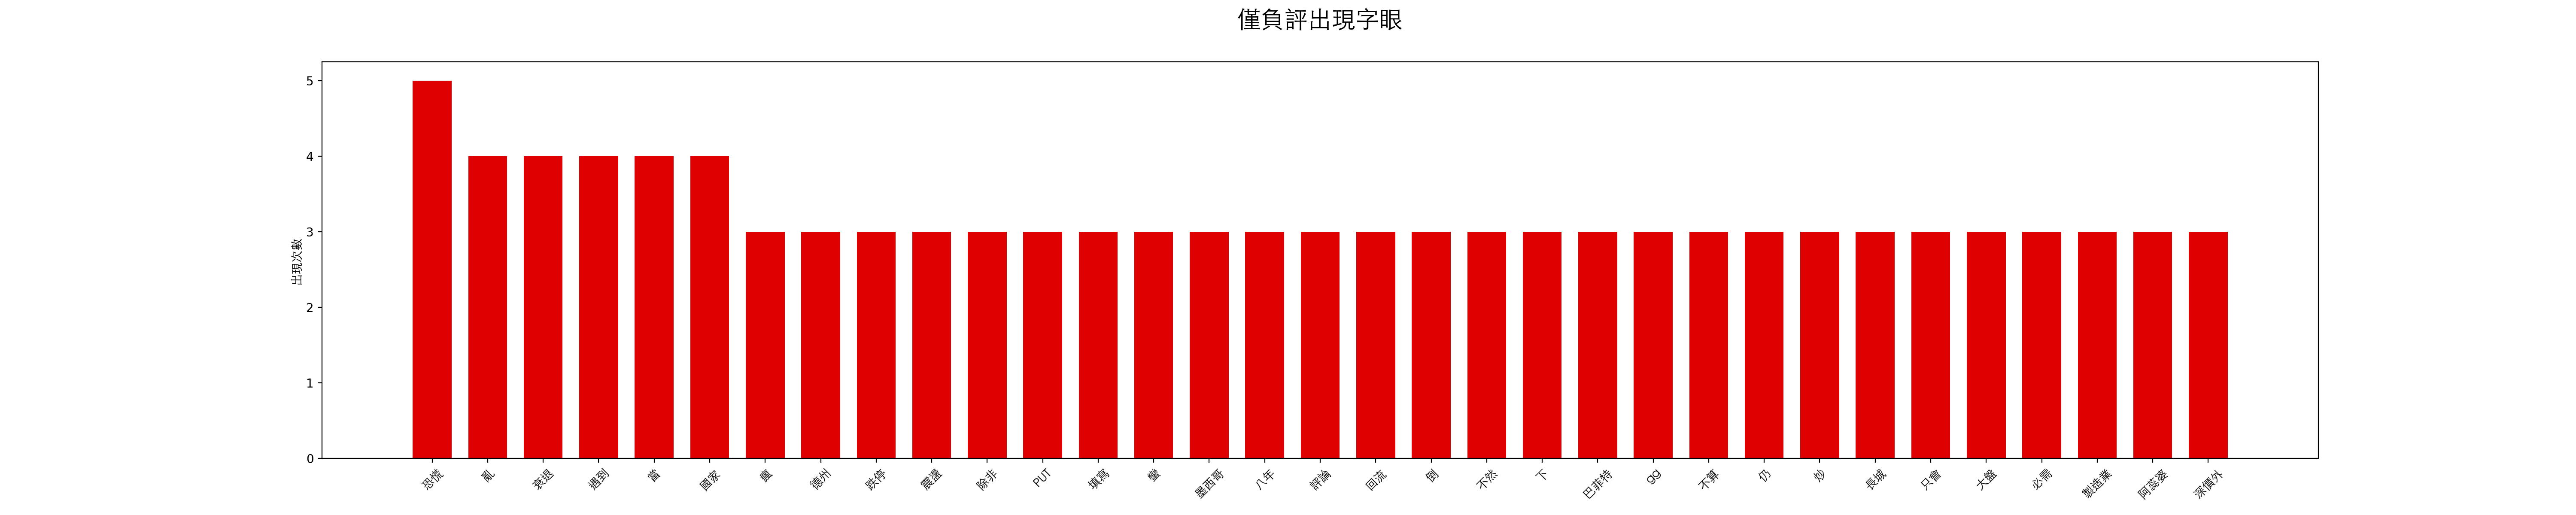

In [19]:
#負評字彙長條圖
plt.figure(figsize=(30,6))
y = negative_data[(negative_data.negative_word.isin(negative_only))&(negative_data.cnt > 2)]['cnt']
label = negative_data[(negative_data.negative_word.isin(negative_only))&(negative_data.cnt > 2)]['negative_word']
x = range(len(y))
width = 0.7
plt.bar(x,y,width = width,color="#DF0101")
plt.xticks(x,label,fontproperties=myfont,rotation=45,fontsize=10)
plt.title(u"僅負評出現字眼\n",fontsize = 20,fontproperties=myfont)
plt.ylabel(u"出現次數",fontproperties=myfont)
plt.show()

In [20]:
#將相關資料匯出，並利用網路資源進行文字雲的繪製
#參考網址：http://www.wordclouds.com/
positive_data[(positive_data.positive_word.isin(positive_only))&(positive_data.cnt > 2)][['cnt','positive_word']].to_csv("../outcome/word_cloud_positive.txt",index=False,encoding='utf-8',sep='\t')
negative_data[(negative_data.negative_word.isin(negative_only))&(negative_data.cnt > 2)][['cnt','negative_word']].to_csv("../outcome/word_cloud_negative.txt",index=False,encoding='utf-8',sep='\t')

In [25]:
#將那些常僅出現在正評/負評且有意義的關鍵字分別寫入positive_word.txt/negative_word.txt
#將結果再次讀入並合併為keyword變數 
positive_keyword = []
for word in open('../outcome/positive_word.txt','r'):
    word = word.replace('\r\n','')
    positive_keyword.append(word)
negative_keyword = []
for word in open('../outcome/negative_word.txt','r'):
    word = word.replace('\r\n','')
    negative_keyword.append(word)
keyword = []
keyword.extend(positive_keyword)
keyword.extend(negative_keyword)
print len(positive_keyword)
print len(negative_keyword)
print len(keyword)

22
21
43


In [29]:
#將訓練資料進行處理
model_data = train_data.drop(['author','dt','sampled'],axis=1)
model_data.columns = ['link','content','support']
model_data = model_data.fillna('')
model_data.loc[:,'seg'] = model_data.content.map(lambda x:list(jieba.cut(x)))
model_data.head()

,link,content,support,seg
0,https://www.ptt.cc/bbs/Stock/M.1464852416.A.66...,由於美國有第三大黨要出候選人 分希拉蕊的票如果剛好就讓 川普當選的話 應該會對美股長期走勢有...,0,"[由, 於, 美國, 有, 第三, 大黨, 要, 出, 候選人, , 分, 希拉蕊, 的,..."
1,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,卻時常在鏡頭面前凸搥的川普如果當選美國總統,-1,"[卻, 時常, 在, 鏡頭, 面前, 凸, 搥, 的, 川普, 如果, 當選, 美國, 總統]"
2,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,桑默斯列舉五大理由解釋為何對川普如此憂心,-1,"[桑默斯, 列舉, 五大, 理由, 解釋, 為何, 對, 川普, 如此, 憂心]"
3,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,當中首要是川普亂無章法的政策風險,-1,"[當中, 首要, 是, 川普, 亂, 無, 章法, 的, 政策, 風險]"
4,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,如川普主張的減稅措施預估可能超過十兆美元,0,"[如, 川普, 主張, 的, 減稅, 措施, 預估, 可能, 超過, 十兆, 美元]"


In [30]:
#看看是否該關鍵字是否存在
for word in keyword:
    word = word.decode('utf-8')
    exec('model_data[u"'+word+'_ind"] = [1 if u"'+word+ '" in x else 0 for x in model_data.seg]')
model_data.head(2)

,link,content,support,seg,﻿候選人_ind,減稅_ind,基礎建設_ind,蘋果_ind,轉彎_ind,罵_ind,...,gg_ind,八年_ind,臺灣_ind,四年_ind,回流_ind,崩潰_ind,長城_ind,躺平_ind,恐慌_ind,QQ_ind
0,https://www.ptt.cc/bbs/Stock/M.1464852416.A.66...,由於美國有第三大黨要出候選人 分希拉蕊的票如果剛好就讓 川普當選的話 應該會對美股長期走勢有...,0,"[由, 於, 美國, 有, 第三, 大黨, 要, 出, 候選人, , 分, 希拉蕊, 的,...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,卻時常在鏡頭面前凸搥的川普如果當選美國總統,-1,"[卻, 時常, 在, 鏡頭, 面前, 凸, 搥, 的, 川普, 如果, 當選, 美國, 總統]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#將執行結果儲存
model_data.to_csv('../outcome/Fin_model_data.csv',index=False,encoding='utf-8')

## 正式開始建模

In [37]:
model_data = pd.read_csv("../outcome/Fin_model_data.csv")

In [39]:
from sklearn import svm

In [40]:
#將言論分為「支持川普」和「不支持川普」兩類
model_data[model_data.support == -1] = 0

In [41]:
X = model_data.drop(['link','content','support','seg'],axis=1).values
Y = model_data['support'].values

In [42]:
model = svm.SVC()
model.fit(X,Y)
model.score(X,Y)

0.79870129870129869

In [44]:
#將測試資料匯入並進行處理
data = pd.read_csv("../outcome/Raw_model_data.csv",encoding='utf-8')
test_data = data[data.sampled == 1]
test_data = test_data.drop(['author','dt','sampled'],axis=1)
test_data.columns = ['link','content','support']
test_data = test_data.fillna('')
test_data.loc[:,'seg'] = test_data.content.map(lambda x:list(jieba.cut(x)))
for word in keyword:
    word = word.decode('utf-8')
    exec('test_data[u"'+word+'_ind"] = [1 if u"'+word+ '" in x else 0 for x in test_data.seg]')
test_data = test_data.drop([u'﻿候選人_ind',u'﻿搞_ind'],axis=1)
print test_data.shape
test_data.head()

(462, 45)


,link,content,support,seg,減稅_ind,基礎建設_ind,蘋果_ind,轉彎_ind,罵_ind,或許_ind,...,gg_ind,八年_ind,臺灣_ind,四年_ind,回流_ind,崩潰_ind,長城_ind,躺平_ind,恐慌_ind,QQ_ind
5,https://www.ptt.cc/bbs/Stock/M.1465187830.A.E2...,以債務達人自居的川普還曾語出驚人的表示美國如果倒債,-1,"[以, 債務, 達人, 自居, 的, 川普, 還曾, 語出, 驚人, 的, 表示, 美國, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,https://www.ptt.cc/bbs/Stock/M.1469527060.A.DD...,其中有 34% 為共和黨總統候選人川普 (Donald Trump) 的支持者,1,"[其中, 有, , 34, %, , 為, 共和黨, 總統, 候選人, 川普, , (...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,https://www.ptt.cc/bbs/Stock/M.1469803288.A.0E...,共和黨總統候選人、企業家川普也堅持退出TPP的主張,0,"[共和黨, 總統, 候選人, 、, 企業家, 川普, 也, 堅持, 退出, TPP, 的, 主張]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,https://www.ptt.cc/bbs/Stock/M.1470293758.A.01...,但別忘了川普是很成功的商人,1,"[但別, 忘, 了, 川普, 是, 很, 成功, 的, 商人]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,https://www.ptt.cc/bbs/Stock/M.1471177914.A.FE...,1.原文連結(必須檢附)：2.原文內容：2016-08-14 02:08:51 經濟日報 編...,0,"[1, ., 原文, 連結, (, 必須, 檢附, ), ：, 2, ., 原文, 內容, ...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#找出在測試資料中完全沒有出現過的字眼
STAT2 = test_data.describe()
STAT2 = STAT2.transpose()
STAT2[STAT2['mean']==float(0)]

,count,mean,std,min,25%,50%,75%,max
基礎建設_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iPhone_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
隊長_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
報導_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
推_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
衰退_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PUT_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
亂_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gg_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
八年_ind,462.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
print "平均出現百分比: " + str(np.mean(STAT2.drop('support')['mean'])*100)
print '有幾個完全沒有出現的關鍵字: ' + str(len(STAT2[STAT2['mean'] == float(0)]['max']))

平均出現百分比: 0.279801499314
有幾個完全沒有出現的關鍵字: 11


In [47]:
X2 = test_data.drop(['link','content','support','seg'],axis=1)
test_data[test_data.support == -1] = 0
X2 = X2.values
ans = test_data['support']
pred = model.predict(X2)
print "實際結果"
print list(ans)
print "SVM預測結果"
print pred #可以看出SVM完全無法針對測試資料進行預測

[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [48]:
#進行logistic建模
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(X,Y)
pred2 = logistic.predict(X2)
pred3 = logistic.predict_proba(X2)

In [49]:
np_ans = np.array(list(ans))
prob = []
for value in pred3:
    p = value[1]
    prob.append(p)
prob = np.array(prob)

In [51]:
print "在未調整的情況下logistic預測是支持川普的index"
print np.where(pred2 == 1)
print ""
print "實際上是支持川普的index"
print np.where(np_ans == 1)
print ""
print "若改以0.19286452 作為門檻值得條件下，預測是支持川普的index"
print np.where(prob > 0.19286452)

在未調整的情況下logistic預測是支持川普的index
(array([ 93, 328, 378]),)

實際上是支持川普的index
(array([  1,   3,   7,  20,  21,  22,  26,  27,  29,  38,  40,  44,  51,
        55,  56,  60,  63,  67,  70,  72,  82,  86,  92,  93,  99, 103,
       118, 135, 141, 142, 147, 148, 158, 161, 179, 180, 181, 182, 189,
       196, 206, 211, 224, 228, 231, 234, 236, 242, 251, 256, 261, 266,
       268, 280, 281, 283, 295, 302, 303, 304, 307, 310, 312, 319, 322,
       328, 342, 358, 366, 385, 399, 403, 407, 408, 422, 429, 447, 461]),)

若改以0.19286452 作為門檻值得條件下，預測是支持川普的index
(array([  1,  56,  93, 139, 152, 154, 169, 189, 194, 226, 243, 268, 303,
       310, 328, 329, 353, 355, 378, 427, 431, 437]),)


In [52]:
ans_loc = set(np.where(np_ans == 1)[0])
pred_loc = set(np.where(prob > 0.19286452)[0])
correct_loc = pred_loc.intersection(ans_loc)
print "涵蓋率: " + str(float(len(correct_loc))/len(ans_loc))
print "精準度: " + str(float(len(correct_loc))/len(pred_loc))

涵蓋率: 0.102564102564
精準度: 0.363636363636
